# Simulating Invasion

Studying the impact of multiphase conditions on transport in porous materials was the original motivation for pore network modeling. OpenPNM includes a set of algorithms for simulating drainage and imbibition, using both ordinary and invasion percolation. These will be covered in this notebook.

In [21]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt

Setup the necessary objects:

In [7]:
pn = op.network.Demo(shape=[20, 20, 1], spacing=1e-4)
water = op.phase.Water(network=pn)
water['pore.contact_angle'] = 120
water.add_model(propname='throat.entry_pressure',
                model=op.models.physics.capillary_pressure.washburn)

## Drainage


In [66]:
drn = op.algorithms.Drainage(network=pn, phase=water)
drn.set_inlet_BC(pores=pn.pores('left'))
drn.run()

Performing drainage simulation: 100%|█████████████████████████████████████████████████| 25/25 [00:00<00:00, 506.59it/s]


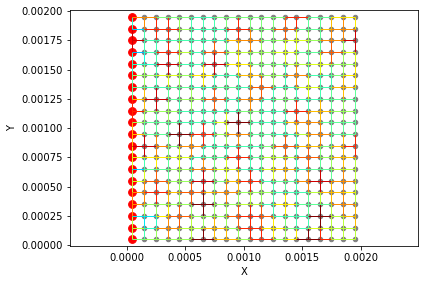

In [67]:
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left'), c='r', s=60)
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left', mode='not'), c='grey', s=20, ax=ax)
op.visualization.plot_connections(network=pn, color_by=drn['throat.invasion_pressure'], ax=ax);

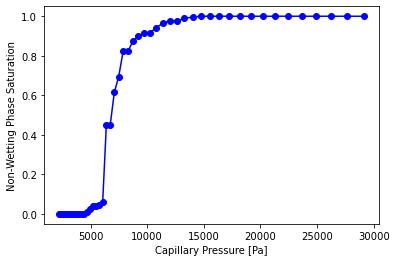

In [68]:
data1 = drn.pc_curve(pressures=50)
plt.plot(data1.pc, data1.snwp, 'b-o')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-Wetting Phase Saturation');

In [69]:
drn.set_outlet_BC(pores=pn.pores('right'))
drn.apply_trapping()

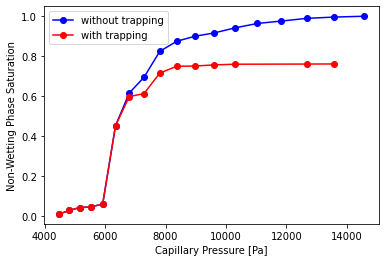

In [70]:
data2 = drn.pc_curve()
plt.plot(data.pc, data.snwp, 'b-o', label='without trapping')
plt.plot(data2.pc, data2.snwp, 'r-o', label='with trapping')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-Wetting Phase Saturation')
plt.legend();

## Imbibition


## Invasion Percolation



In [71]:
ip = op.algorithms.InvasionPercolation(network=pn, phase=water)
ip.set_inlet_BC(pores=pn.pores('left'))
ip.run()

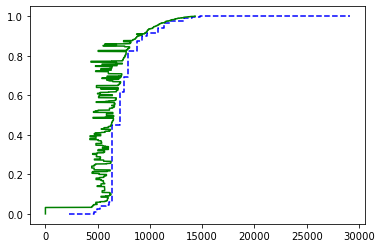

In [76]:
data_ip = ip.pc_curve()
plt.step(data1.pc, data1.snwp, 'b--', where='post')
plt.plot(data_ip.pc, data_ip.snwp, c='green');